In [109]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras import layers, models

from encoding import Encoding

In [110]:
keras.__version__, K.tf.__version__

('2.2.0', '1.8.0')

## Toy Setup Demo

In [114]:
k = 3        # number of codewords to learn
h, w = 4,5   # conv filter dims (feature vectors)
d = 12       # number of conv filters (features)

conv_input = layers.Input(shape=(h,w,d,), name='features')

X = layers.Reshape(target_shape=(h*w,d,), name='collapse')(conv_input)

E = Encoding(d, k, name='encoding')(X)

simple_enc = models.Model(inputs=conv_input, outputs=E)
simple_enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 4, 5, 12)          0         
_________________________________________________________________
collapse (Reshape)           (None, 20, 12)            0         
_________________________________________________________________
encoding (Encoding)          (3, 12)                   39        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [115]:
x = np.random.random(size=(h,w,d))
print(x.shape)

x_encoded = simple_enc.predict_on_batch(x[np.newaxis,...])
print(x_encoded.shape)

(4, 5, 12)
(3, 12)


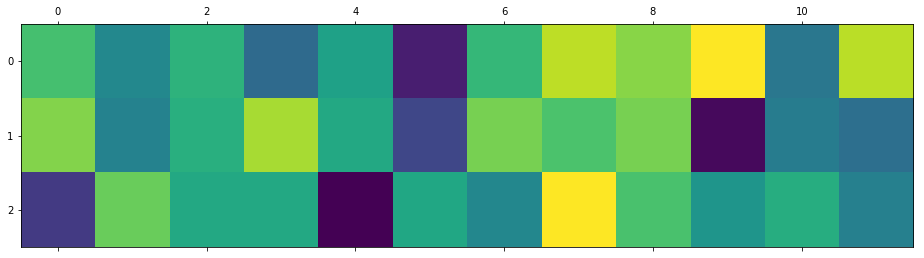

In [116]:
# Visualize the initial codebook
plt.matshow(simple_enc.get_layer('encoding').get_weights()[0])

## Pre-trained Conv Features Demo

In [117]:
from keras.applications import resnet50

In [137]:
# shouldn't need an input_shape, but K.reshape seems to have a problem with 3 `None`s
resnet_base = resnet50.ResNet50(include_top=False, input_shape=(448,448,3))

print(resnet_base.layers[-5].output_shape)
print(resnet_base.output_shape)

In [145]:
# We'll take the last 3x3 conv to have 512 instead of 2048 features
# in original paper, they instead add a 1x1 conv (2048->128)
x = resnet_base.layers[-5].output
x = layers.Reshape(target_shape=(14*14, 512))(x)

K = 32
x = Encoding(512, K, name='texture_encoding')(x)
# Should add vector-wise L2 norm here
enc = layers.Flatten()(x)
preds = layers.Dense(10, activation='softmax')(enc)

encode_model = models.Model(inputs=resnet_base.input, outputs=[x,preds])

ValueError: Input 0 is incompatible with layer flatten_1: expected min_ndim=3, found ndim=2

In [143]:
encode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 454, 454, 3)  0           input_38[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 224, 224, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [144]:
x = np.random.random(size=(448,448,3))

encoding, pred = encode_model.predict_on_batch(x[np.newaxis,...])
print(encoding.shape, pred.shape)

(32, 512) (32, 10)
